<img src="images/trump_sample_tweet.png">
Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most
influential figures during the pandemic – but in the end, was he that influential? Will causal analyses of the effect of
Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our
goal is to study the impact an influential leader can have on information spread in a
crisis with a focus on fake news, as an overload of misleading or contradictory
statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis
management. To provide a more comprehensive insight into Trump’s actual influence
on online information spread, we would then like to compare it with that of other
factors such as mobility restrictions or key milestones (e.g. first Covid death). Trump
the Trend Maker or Trump the Follower, that is the question!


## Imports :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

import statsmodels.formula.api as smf

import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Local Modules
from extra_material.wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from extra_material.wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from extra_material.wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from extra_material.wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from extra_material.wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

import statsmodels.formula.api as smf
from sklearn import metrics
from scipy.stats import ttest_ind
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

#vader
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dandr_wh38grr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


---
# Part 0: Pre-processing

### A) We start by preparing and familiarizing with our data

Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present Donald Trump's tweets dataset 

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
32418,666459170552553472,Thank you Tennessee! #Trump2016 https://t.co/R...,f,f,Twitter for iPhone,5008,2230,2015-11-17,f
49264,955458357200130049,End the Democrats Obstruction! https://t.co/tz...,f,f,Twitter for iPhone,77983,16874,2018-01-22,f
26495,537746116557934593,@tiberias84. Thank you! @macy's,f,f,Twitter for Android,3,3,2014-11-26,f
22377,331993602521702400,"""""""@calikal69: @realDonaldTrump what do you th...",f,f,Twitter for Android,134,131,2013-05-08,f
31878,676029050536796160,"""""""@StraightHand: @realDonaldTrump I'd pay to ...",f,f,Twitter for Android,1958,625,2015-12-13,f


There is no empty row in the dataset :

In [4]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on the Covid period:

In [5]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Let's check whether Donald Trump Tweeted every day :

In [6]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


Since there is only one day where he didn't tweet, we can drop this day from our dataset, it won't affect our analysis.

In [7]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')
data_t = data.copy()

We can have a look at the temporal evolutions of Trump's tweets :

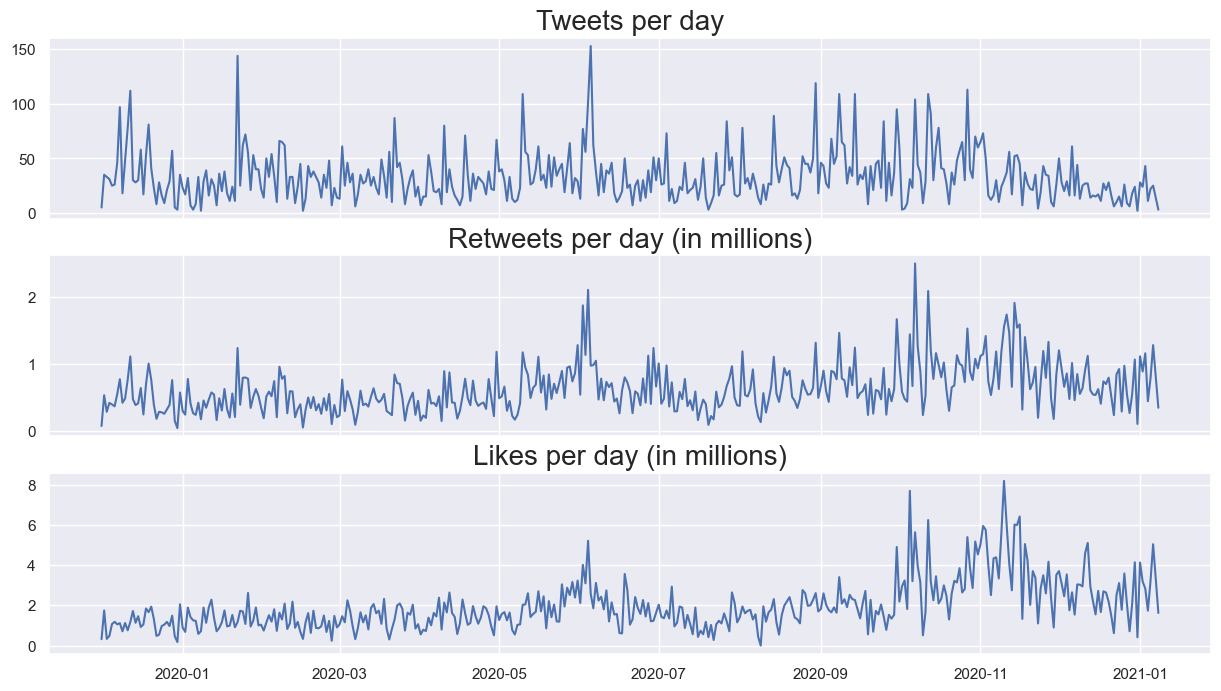

In [131]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False, figsize = (15,8))
fig

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=20)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=20)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=20)

plt.show()

Let's have an idea of the type of tweets we have :

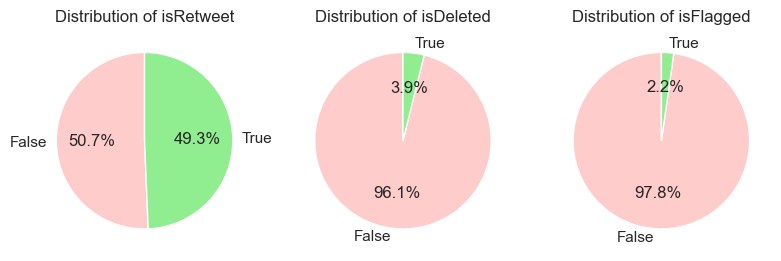

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though this can be an indication of misinformation spreaded by Trump.

Use spacy to get rid of stop words in the tweets. Stop words are all that words such as and, or, that, etc. that are not relevant for a tweet but are used very often.

In [10]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


Let's have a look at the most used words in Trump's tweets :

In [11]:
df_clean = data.copy()

df_clean['text'] = df_clean['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',x))

df_clean['text'] = df_clean['text'].apply(lambda x: x.lower())

for punctuation in [',', '.', ':', ';', '?', '!', '"', '/', '|', "'"]:
    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(punctuation, ' '))

for word in ['@realdonaldtrump', 'realdonaldtrump', 'rt', '&amp','trump', 'thank', 'people', 'great', 's']:

    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(' '+word+' ', ' '))

df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('rt ', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('thank', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('president', ''))

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))

def remove_stopwords(texts, spacy_stopwords):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in spacy_stopwords] for doc in texts]

In [13]:
dataframe = df_clean['text'].values.tolist()
data_words = list(sent_to_words(dataframe))
data_words = remove_stopwords(data_words, spacy_stopwords)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


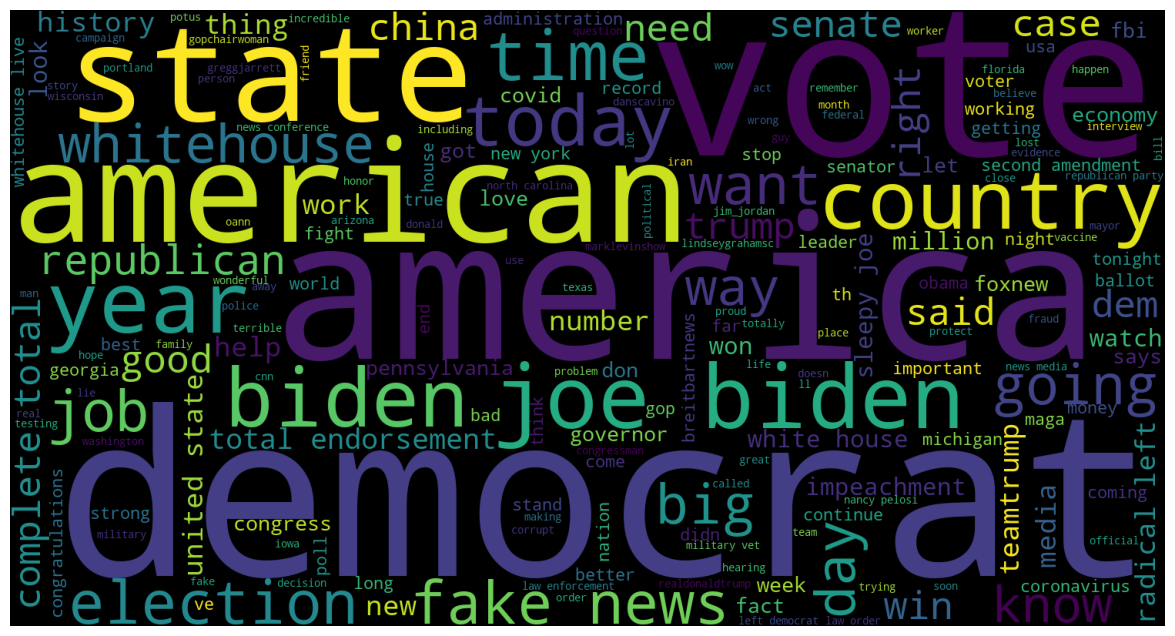

In [14]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As we can see, there are not that much related to covid. Though one can already spot some of his favorite topics.

Let's focus our analysis on Covid-related tweets

In [15]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']

df_clean['covid_related'] = df_clean['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

df_clean['covid_related'].value_counts()

covid_related
False    12776
True       742
Name: count, dtype: int64

In [16]:
#data where covid_related is true
data_covid_rel = df_clean[df_clean['covid_related']==1]

In [17]:
df_temp = data_covid_rel[(data_covid_rel['date']>=datetime(2020,3,8))&(data_covid_rel['date']<=datetime(2020,4,24))]

Following the same process, we can have a look at the most used words in Trump's Covid related tweets :

In [18]:
dataframe = data_covid_rel['text'].values.tolist()
data_words = list(sent_to_words(dataframe))
data_words = remove_stopwords(data_words, spacy_stopwords)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


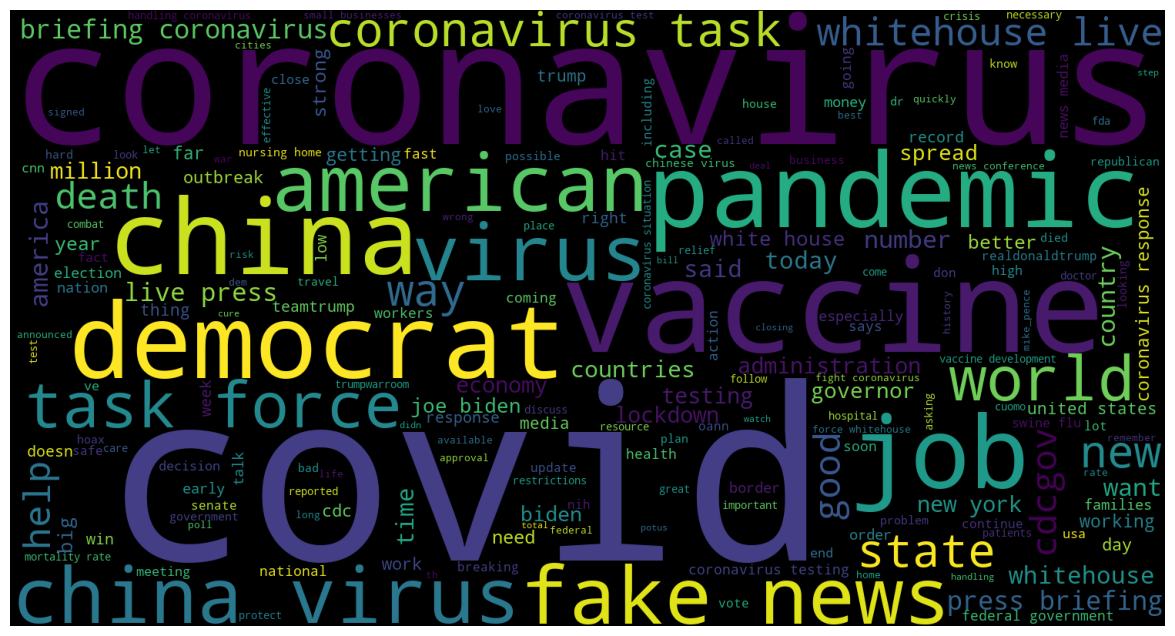

In [19]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This image shows a more spreaded distribution of words. Though, one can spot the importance of china,vaccine ,chinese virus or even swine flu in his tweets. Lots of words were also related to actions such as Task Force, Live Press or Briefing.

Let's find the moment when Trump tweeted the most about Covid:

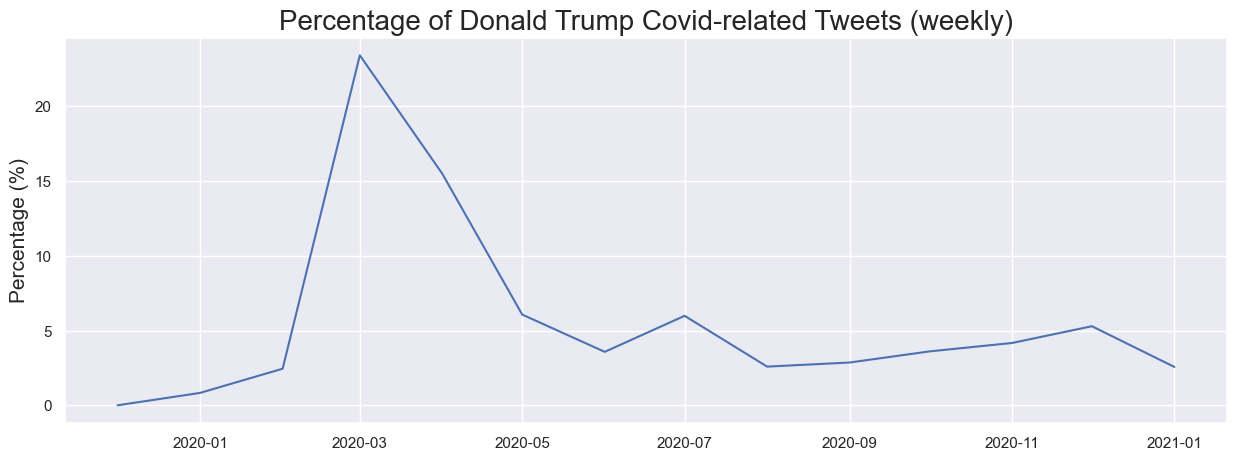

In [132]:
df_clean['month_date'] = df_clean.date.apply(lambda x: x.month)
df_clean['year_date'] = df_clean.date.apply(lambda x: x.year)
frequency_plot = df_clean.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

#plot the percentage of covid related tweets
plt.figure(figsize=(15, 5)) 
plt.ylabel('Percentage (%)', size = 15)
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)', size = 20)
plt.show()

As we can see the highest density of covid related tweets is in March 2020, which is the beginning of the pandemic in the US. In March the percentage peaked at 20%. We can also see that the density of covid related tweets is decreasing over time.

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid:

In [21]:
data = df_clean
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

Not all tweets have the same impact on public opinion, hence we want to see in which period covid related tweets were among the most relevant, to adress importance we use retweet as a proxy.

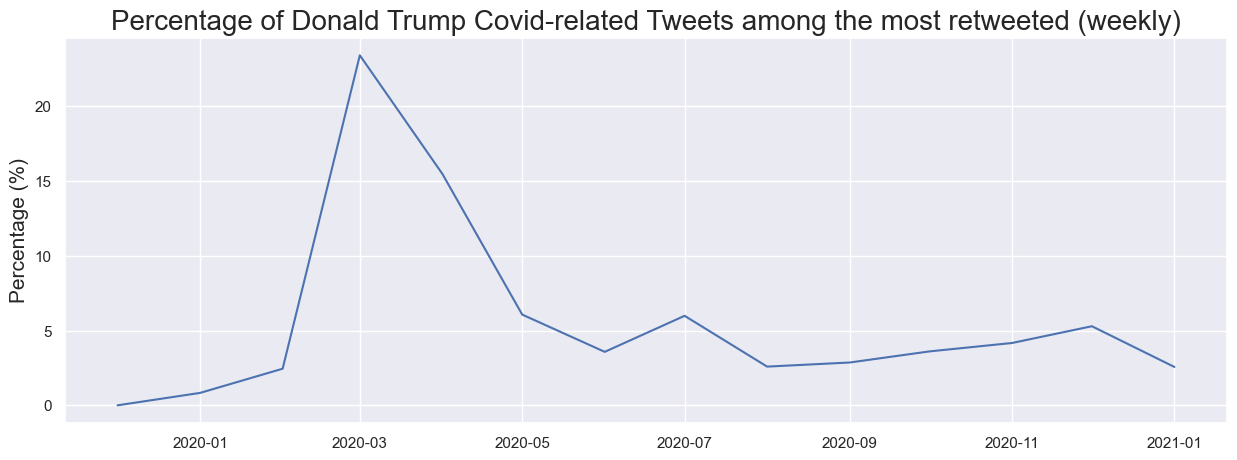

In [133]:
frequency_plot1 = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot1['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot1.month_date.values, frequency_plot1.year_date.values)]
frequency_plot1 = frequency_plot1.sort_values(by='date')

plt.figure(figsize=(15, 5)) 
plt.ylabel('Percentage (%)', size=15)
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)', size=20)
plt.show()

**As we can see the moment were we had the highest share of covid related tweets (March 2020) is also the moment we had also the highest number of tweets related to covid.**

## Mobility analysis
Show how during the pandemic, as people spent more time at home, the online traffic increase, there should be a direct correlation

In [23]:
# Importing mobility reports, 
timeseries_dict = load_aggregated('./extra_material/wiki_pageviews_covid/data/aggregated_timeseries.json.gz')
google_df = pd.read_csv('./extra_material/wiki_pageviews_covid/data/Global_Mobility_Report.csv.gz', compression="infer")

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\1882118261.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  google_df = pd.read_csv('./extra_material/wiki_pageviews_covid/data/Global_Mobility_Report.csv.gz', compression="infer")


In [24]:
# We're only interested in the US, so we keep only the component about the US
mobility_us_df = google_df[google_df.country_region_code == 'US'].drop(columns=['country_region', 'country_region_code']).copy()
mobility_us_df['date'] = pd.to_datetime(mobility_us_df['date'])

# We're interested in the complete and states values, so we can discard the the values for which sub_region_2 is not null
mobility_us_df = mobility_us_df[mobility_us_df.sub_region_2.isna()].drop(columns=['sub_region_2','metro_area','iso_3166_2_code','census_fips_code'])

In [25]:
general_df = mobility_us_df[(mobility_us_df.sub_region_1.isna()) & (mobility_us_df.date >= datetime(year=2020, month=2, day=15)) & (mobility_us_df.date <= datetime(year=2020, month=7, day=15))]
general_df = general_df[['date', 'residential_percent_change_from_baseline']]

weekday_general_df = general_df[general_df.date.dt.weekday <= 4].set_index('date')
weekend_general_df = general_df[general_df.date.dt.weekday > 4].set_index('date')

general_df = general_df.set_index('date')
weekly_general_df = general_df.resample('W-Mon').mean()

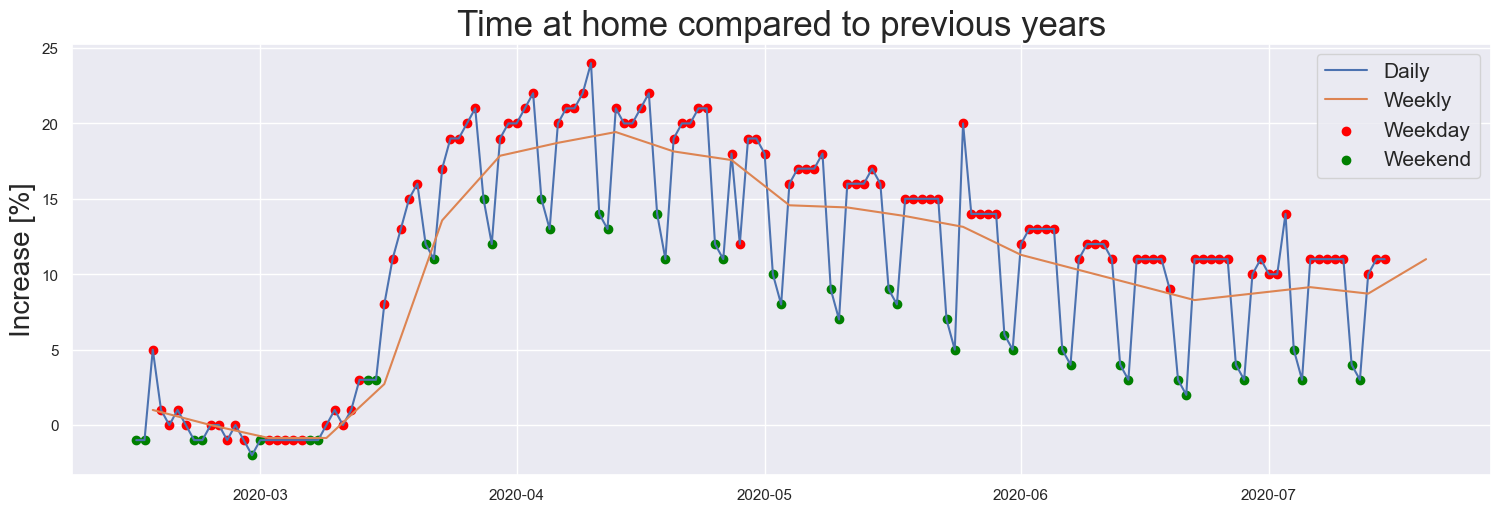

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
fig.tight_layout(h_pad=5)

ax.set_title('Time at home compared to previous years', size=25)
ax.set_ylabel('Increase [%]', size=20)
# ax.set_xlabel('Date', size=15)
ax.plot(general_df)
ax.plot(weekly_general_df)
ax.scatter(weekday_general_df.index, weekday_general_df, color='red')
ax.scatter(weekend_general_df.index, weekend_general_df, color='green')
ax.legend(['Daily', 'Weekly', 'Weekday', 'Weekend'], fontsize=15)

Interesting consideration, there is a difference between the change in mobility during the week (where people always go out for working) and during the weekend (where also normally people sometimes stay at home), this is clear looking at the daily plot, so it's beneficial to use the weekly one instead

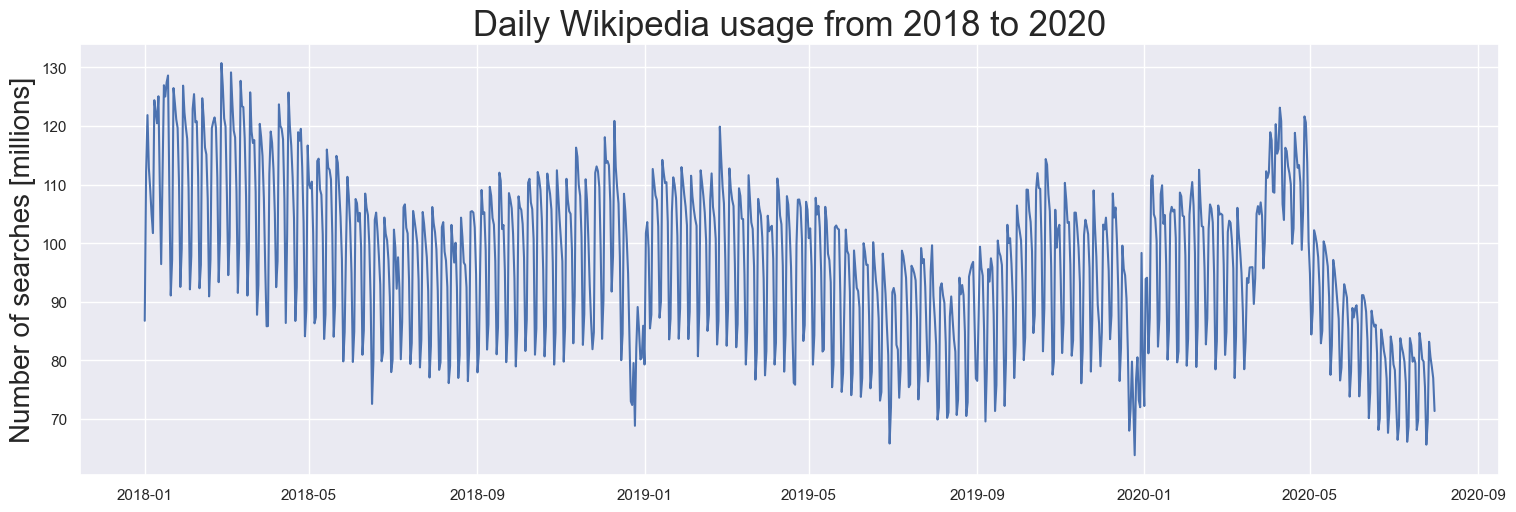

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
fig.tight_layout(h_pad=5)

ax.set_title('Daily Wikipedia usage from 2018 to 2020', size=25)
ax.set_ylabel('Number of searches [millions]', size=20)
# ax.set_xlabel('Date', size=15)
ax.plot(timeseries_dict['en']['sum'] / 10**6)

From the plot above, it can be seen how the popularity of wikipedia is slightly decreasing over the years, we have to take this into account in our analysis

In [28]:
decrease_factor = ((np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                   - np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])) \
                   / np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])).mean()

In [29]:
total_searches_before = (np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                       + np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)] * (1 + decrease_factor))) / 2
total_searches_2020 = np.array(timeseries_dict['en']['sum'].loc[datetime(year=2020, month=2, day=15):datetime(year=2020, month=7, day=15)]) * (1 + decrease_factor)**2
total_searches_increase = 100 * (total_searches_2020 / total_searches_before - 1)

date_range = pd.date_range(datetime(year=2020, month=2, day=15), datetime(year=2020, month=7, day=15))

total_searches_increase = pd.DataFrame({'date': date_range, 'increase': total_searches_increase})#.set_index('date')
weekday_searches_increase = total_searches_increase[total_searches_increase.date.dt.weekday <= 4].set_index('date')
weekend_searches_increase = total_searches_increase[total_searches_increase.date.dt.weekday > 4].set_index('date')

total_searches_increase = total_searches_increase.set_index('date')
weekly_total_searches_increase = total_searches_increase.resample('W-Mon').mean()

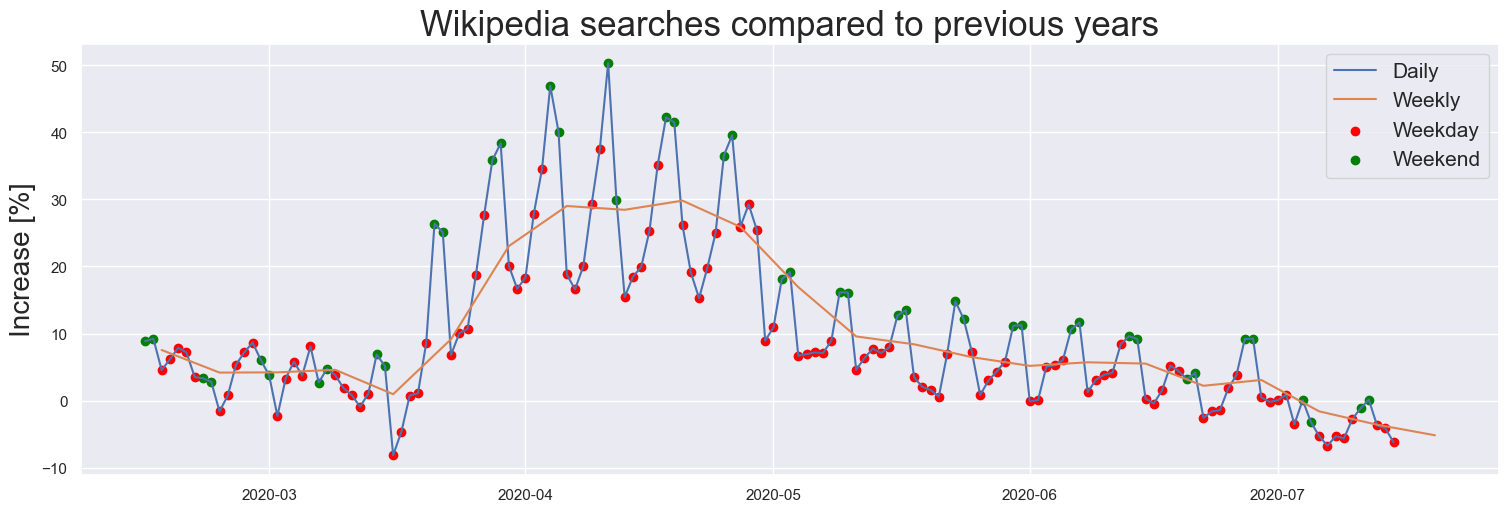

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
# fig.suptitle('Comparison between time spent at home and wikipedia searches between 2020 and previous years', size=20)
fig.tight_layout(h_pad=5)

ax.set_title('Wikipedia searches compared to previous years', size=25)
ax.set_ylabel('Increase [%]', size=20)
# ax.set_xlabel('Date', size=15)
ax.plot(total_searches_increase)
ax.plot(weekly_total_searches_increase)
ax.scatter(weekday_searches_increase.index, weekday_searches_increase, color='red')
ax.scatter(weekend_searches_increase.index, weekend_searches_increase, color='green')
ax.legend(['Daily', 'Weekly', 'Weekday', 'Weekend'], fontsize=15)

The plot intuition is confirmed by applying a linear regression

In [31]:
# Getting OLS for day, week, weekdays and weekends
weekly_data = pd.DataFrame()
weekly_data['x'] = weekly_general_df
weekly_data['y'] = weekly_total_searches_increase

daily_data = pd.DataFrame()
daily_data['x'] = general_df
daily_data['y'] = weekly_total_searches_increase

weekday_data = pd.DataFrame()
weekday_data['x'] = weekday_general_df
weekday_data['y'] = weekday_searches_increase

weekend_data = pd.DataFrame()
weekend_data['x'] = weekend_general_df
weekend_data['y'] = weekend_searches_increase

# compute the different 
weekly_mod = smf.ols(formula='y ~ x', data=weekly_data)
daily_mod = smf.ols(formula='y ~ x', data=daily_data)
weekday_mod = smf.ols(formula='y ~ x', data=weekday_data)
weekend_mod = smf.ols(formula='y ~ x', data=weekend_data)

weekly_res = weekly_mod.fit()
daily_res = daily_mod.fit()
weekday_res = weekday_mod.fit()
weekend_res = weekend_mod.fit()

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

In [32]:
print(weekly_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     19.27
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           0.000256
Time:                        15:09:45   Log-Likelihood:                -78.975
No. Observations:                  23   AIC:                             161.9
Df Residuals:                      21   BIC:                             164.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4080      3.177     -0.758      0.4

In [33]:
print(daily_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     15.56
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           0.000802
Time:                        15:09:45   Log-Likelihood:                -75.812
No. Observations:                  22   AIC:                             155.6
Df Residuals:                      20   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2931      3.598     -0.637      0.5

Doing daily or weekly regressions give very similar results, both have good predictive power and similar coefficients (1.14 and 1.0).

In [34]:
print(weekday_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     55.08
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           3.03e-11
Time:                        15:09:45   Log-Likelihood:                -379.42
No. Observations:                 108   AIC:                             762.8
Df Residuals:                     106   BIC:                             768.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9873      1.628     -1.835      0.0

In [35]:
print(weekend_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     137.4
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           7.94e-15
Time:                        15:09:45   Log-Likelihood:                -148.24
No. Observations:                  44   AIC:                             300.5
Df Residuals:                      42   BIC:                             304.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9455      1.696      0.557      0.5

As expected, weekdays have a lower coefficient of 0.84, while weekends have a higher coefficient of 2.5192, this means that an increase in the time spent at home during the weekend is much more powerful than a weekday spent at home, for the number of Wikipedia searches done

# Part 1: Automatized Topic clustering using latent dirichlet allocation

we slice the dataset so that we we take into account only the most interesting period related to covid, which is from start of march to late may 2020

In [122]:
df_cov_period = df_clean[(df_clean['date']>'01-03-2020')&(df_clean['date']<'31-05-2020')]

data1 = df_cov_period['text'].values.tolist()
data_words = list(sent_to_words(data1))
data_words = remove_stopwords(data_words, spacy_stopwords)

id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

num_topics = 3

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"whitehouse" + 0.005*"coronavirus" + 0.004*"democrats" + '
  '0.004*"biden" + 0.003*"new" + 0.003*"joe" + 0.003*"live" + 0.003*"obama" + '
  '0.003*"house" + 0.003*"force"'),
 (1,
  '0.007*"democrats" + 0.007*"news" + 0.006*"house" + 0.006*"new" + '
  '0.005*"impeachment" + 0.005*"coronavirus" + 0.005*"american" + 0.004*"like" '
  '+ 0.004*"fake" + 0.004*"america"'),
 (2,
  '0.005*"today" + 0.005*"state" + 0.004*"news" + 0.004*"media" + '
  '0.004*"democrats" + 0.004*"coronavirus" + 0.004*"whitehouse" + 0.004*"good" '
  '+ 0.004*"democrat" + 0.003*"american"')]


In [123]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.col

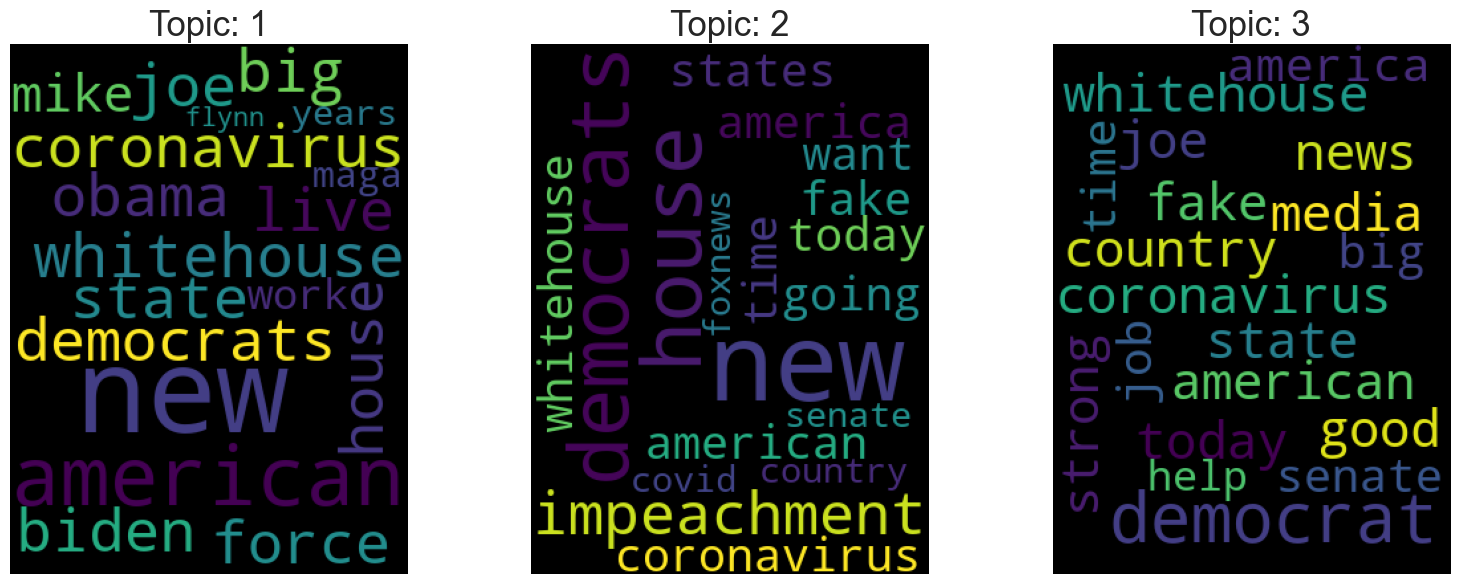

In [135]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6)) 

for topic_id, topic in enumerate(lda_model.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=300, height=400, random_state=21).generate(topic_words)

    axs[topic_id].imshow(wordcloud)
    axs[topic_id].axis("off")
    axs[topic_id].set_title("Topic: {}".format(topic_id+1), size = 25)

plt.tight_layout()
plt.show()

As we can see we cannot draw many conclusions based on the automatic clustering, so we decided to select the topics manually

# Part 2: Etienne's'

## Data parsing

## Sentiment analysis 

In [39]:
sid = SentimentIntensityAnalyzer()

In [40]:
data['scores'] = data['text'].apply(lambda Description: sid.polarity_scores(Description))  

#calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,'sentiment_type']='POSITIVE'
data.loc[data.compound==0,'sentiment_type']='NEUTRAL'
data.loc[data.compound<0,'sentiment_type']='NEGATIVE'

## Covid related

In [41]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]

t-test between covid related and non related mean of retweets :

In [42]:
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]
comparison_covid = pd.DataFrame({'Covid related':data_covid_rel.retweets, 'Non covid related':data_not_covid_rel.retweets})

t_stat, p_value_covid = ttest_ind(data_covid_rel.retweets, data_not_covid_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_covid.round(5))

The p-value of the t-test is 0.01859


## LeakTheory related

In [43]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())


Number of tweets talking about COVID-19 lab leak theory is:  49


In [44]:
data_Leaktheory_rel = data[data['Leaktheory']==1]
data_not_Leaktheory_rel = data[data['Leaktheory']==0]
comparison_Leaktheory = pd.DataFrame({'Leaktheory related':data_Leaktheory_rel.retweets, 'Non Leaktheory related':data_not_Leaktheory_rel.retweets})

t_stat, p_value_Leaktheory = ttest_ind(data_Leaktheory_rel.retweets, data_not_Leaktheory_rel.retweets, equal_var=False)
print('The p-value is', p_value_Leaktheory.round(5))

The p-value is 1e-05


## Swine flu related

In [45]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col

In [46]:
data_Swineflu_rel = data[data['Swineflu']==1]
data_not_Swineflu_rel = data[data['Swineflu']==0]
comparison_Swineflu = pd.DataFrame({'Swineflu related':data_Swineflu_rel.retweets, 'Non Swineflu related':data_not_Swineflu_rel.retweets})

t_stat, p_value_Swineflu = ttest_ind(data_Swineflu_rel.retweets, data_not_Swineflu_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Swineflu.round(5))

The p-value of the t-test is 0.00485


## Hydroxychloroquine related

In [47]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  26


In [48]:
data_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==1]
data_not_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==0]
comparison_Hydroxychloroquine = pd.DataFrame({'Hydroxychloroquine related':data_Hydroxychloroquine_rel.retweets, 'Non Hydroxychloroquine related':data_not_Hydroxychloroquine_rel.retweets})

t_stat, p_value_Hydroxychloroquine = ttest_ind(data_Hydroxychloroquine_rel.retweets, data_not_Hydroxychloroquine_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Hydroxychloroquine.round(5))

The p-value of the t-test is 0.33731


## Biden related

In [49]:
biden = ['Joe Biden','biden','joe','Joe','Biden','sleepy']
analyze_biden = data['text'].apply(lambda x: True if any(word in x for word in biden) else False)

# create a new column with the result of the analysis
new_col = analyze_biden.reindex(data.index, fill_value=False)
data['biden'] = new_col
print('Number of tweets talking about biden is: ', data['biden'].sum())


Number of tweets talking about biden is:  1169


In [50]:
data_biden_rel = data[data['biden']==1]
data_not_biden_rel = data[data['biden']==0]
comparison_biden = pd.DataFrame({'biden related':data_biden_rel.retweets, 'Non biden related':data_not_biden_rel.retweets})

t_stat, p_value_biden = ttest_ind(data_biden_rel.retweets, data_not_biden_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_biden.round(5))

The p-value of the t-test is 0.0


## Democrats related

In [51]:
democrats = ['Democrats','democrats','Dems','dems']
analyze_democrats = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_democrats.reindex(data.index, fill_value=False)
data['democrats'] = new_col
print('Number of tweets talking about democrats is: ', data['democrats'].sum())

Number of tweets talking about democrats is:  894


In [52]:
data_democrats_rel = data[data['democrats']==1]
data_not_democrats_rel = data[data['democrats']==0]
comparison_democrats = pd.DataFrame({'democrats related':data_democrats_rel.retweets, 'Non democrats related':data_not_democrats_rel.retweets})

t_stat, p_value_democrats = ttest_ind(data_democrats_rel.retweets, data_not_democrats_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_democrats.round(5))

The p-value of the t-test is 0.63767


## Vaccines related

In [53]:
vaccines = ['vaccines','Vaccines','vax','Vax','vaccin']
analyze_vaccines = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_vaccines.reindex(data.index, fill_value=False)
data['vaccines'] = new_col
print('Number of tweets talking about vaccines of the t-test is: ', data['vaccines'].sum())

Number of tweets talking about vaccines of the t-test is:  894


In [54]:
data_vaccines_rel = data[data['vaccines']==1]
data_not_vaccines_rel = data[data['vaccines']==0]
comparison_vaccines = pd.DataFrame({'vaccines related':data_vaccines_rel.retweets, 'Non vaccines related':data_not_vaccines_rel.retweets})


t_stat, p_value_vaccines = ttest_ind(data_vaccines_rel.retweets, data_not_vaccines_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_vaccines.round(5))

The p-value of the t-test is 0.63767


## Aggregate results into more general categories:

In [55]:
data['is_fake_news'] = (data['Hydroxychloroquine']|data['Swineflu']|data['Leaktheory'])
data['is_democrats_related'] = (data['biden']|data['democrats'])

In [56]:
data['is_democrats_related'] .sum()

1984

In [57]:
data_fake_news_rel = data[data['is_fake_news']==1]
data_not_fake_news_rel = data[data['is_fake_news']==0]
comparison_fake_news = pd.DataFrame({'fake_news related':data_fake_news_rel.retweets, 'Non fake_news related':data_not_fake_news_rel.retweets})


t_stat, p_value_fake_news = ttest_ind(data_fake_news_rel.retweets, data_not_fake_news_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_fake_news.round(5))

The p-value of the t-test is 1e-05


## Plots of number of rewteets by topics:

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldc

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldc

[Text(0, 0.5, 'Number of retweets')]

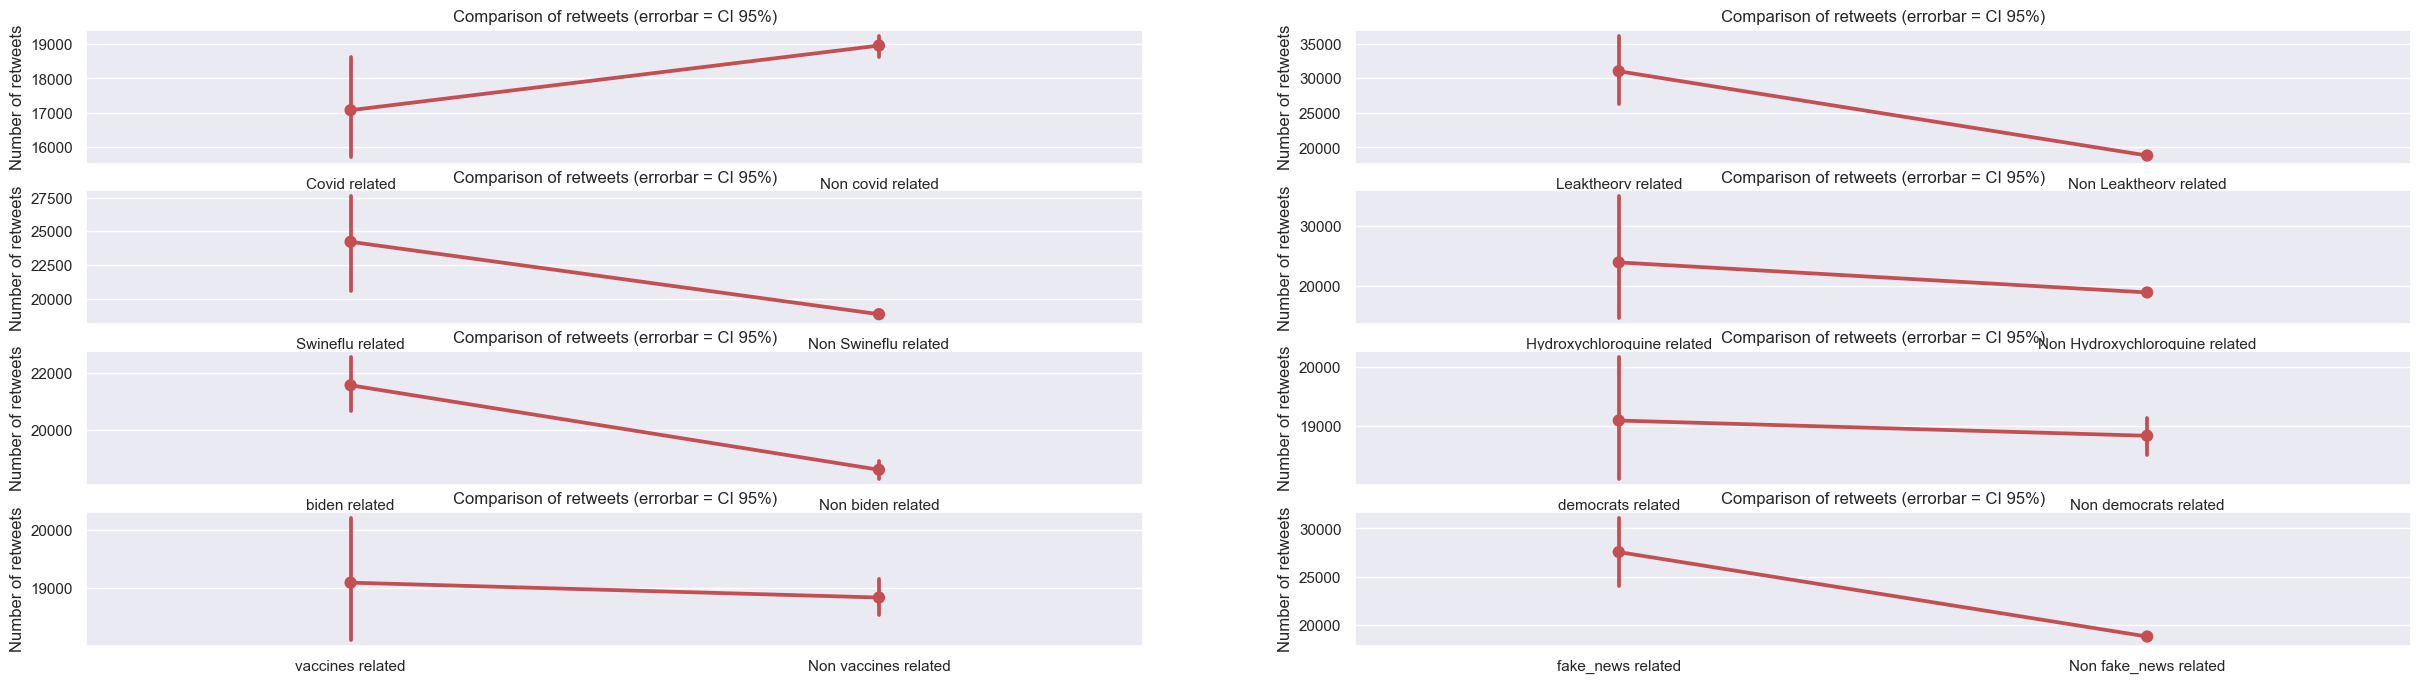

In [58]:
fig, axs = plt.subplots(4, 2,figsize=(30,8))

ax0 = sns.pointplot(data=comparison_covid, ax=axs[0, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax0 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax0 .set(ylabel='Number of retweets')

ax1 = sns.pointplot(data=comparison_Leaktheory,ax=axs[0, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax1 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax1 .set(ylabel='Number of retweets')

ax2 = sns.pointplot(data=comparison_Swineflu, ax=axs[1, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax2 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax2 .set(ylabel='Number of retweets')

ax3 = sns.pointplot(data=comparison_Hydroxychloroquine, ax= axs[1, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax3 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax3 .set(ylabel='Number of retweets')

ax4 = sns.pointplot(data=comparison_biden,ax=axs[2, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax4 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax4 .set(ylabel='Number of retweets')

ax5 = sns.pointplot(data=comparison_democrats, ax=axs[2, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax5 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax5 .set(ylabel='Number of retweets')

ax6 = sns.pointplot(data=comparison_vaccines, ax=axs[3, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax6 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax6 .set(ylabel='Number of retweets')

ax7 = sns.pointplot(data=comparison_fake_news, ax=axs[3, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax7 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax7 .set(ylabel='Number of retweets')

## Regression to disentangle categories into predicting the number of retweets:

In [59]:
mod_retweets = smf.ols(formula='retweets ~ C(covid_related)+C(is_fake_news)+C(sentiment_type)', data=data)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

In [60]:
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     28.25
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.11e-23
Time:                        15:10:40   Log-Likelihood:            -1.5161e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13513   BIC:                         3.033e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Compare number of retweets per categories :

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldc

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

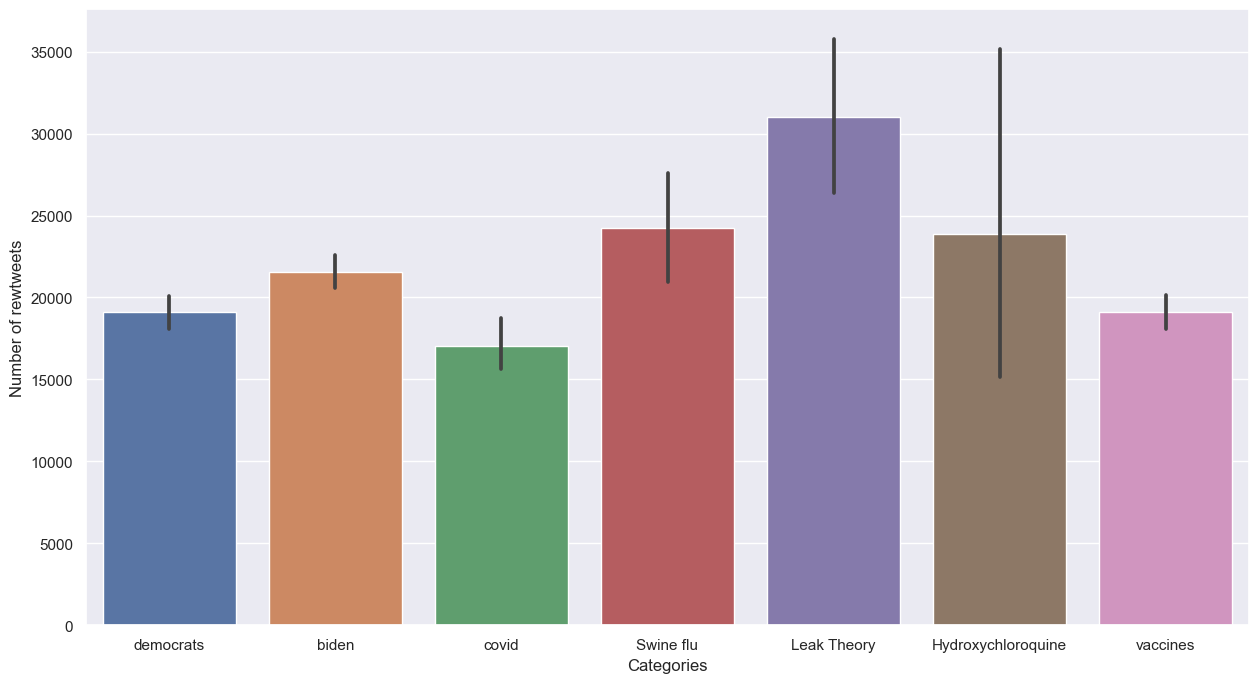

In [61]:
compare_retweets = pd.DataFrame({'democrats':data_democrats_rel.retweets,'biden':data_biden_rel.retweets,
                    'covid':data_covid_rel.retweets,'Swine flu':data_Swineflu_rel.retweets,
                     'Leak Theory':data_Leaktheory_rel.retweets,'Hydroxychloroquine':data_Hydroxychloroquine_rel.retweets,
                               'vaccines':data_vaccines_rel.retweets})

ax = sns.barplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

# Studying sentiment

Add one hot encoding of sentiment:

In [62]:
data =data.merge(pd.get_dummies(data['sentiment_type']), left_index=True, right_index=True)

## Sentiment distributions

sentiment_type
POSITIVE    5306
NEUTRAL     4227
NEGATIVE    3985
Name: count, dtype: int64


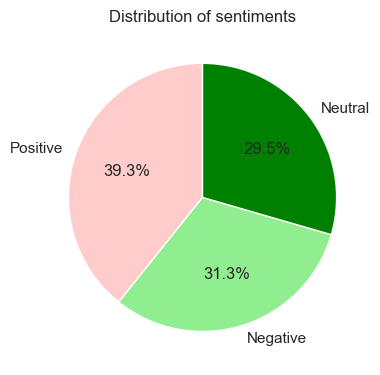

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(4, 4))

var = 'sentiment_type'
colors = ['#FFCCCC', 'lightgreen','green']
print(data[var].value_counts())
plt.pie(data[var].value_counts(), labels=['Positive', 'Negative','Neutral'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title(f'Distribution of sentiments')

plt.tight_layout()

**DT is actually a positive guy!**

Show a few tweets:

In [64]:
data[data.sentiment_type=='POSITIVE'].text

0        “sen  tim scott says  innocent    no way  sena...
1            in america  community by community where w...
6        @cnbc  this year is shaping up to be one of th...
7        just landed in the united kingdom  heading to ...
8        the fed should lower rates (there is almost no...
                               ...                        
13510    mike pence didn’t have the courage to do what ...
13511    please suppoour capitol police and law enforce...
13512    i am asking for everyone at the u  capitol to ...
13514    these are the things and events that happen wh...
13517    the 75 000 000 american patriots who voted for...
Name: text, Length: 5306, dtype: object

In [65]:
data[data.sentiment_type=='NEUTRAL'].text

4        “trump did nothing impeachable  day-by-day rev...
10                                                        
12        @thehill  #breaking  ukraine zelensky  i neve...
13        you to  zelensky  case over  the do nothing d...
26       “the democrats don’t have any evidence  but th...
                               ...                        
13507                          even mexico uses voter i d 
13509                                                     
13513                                                     
13516                                                     
13518    to all of those who have asked  i will not be ...
Name: text, Length: 4227, dtype: object

In [66]:
data[data.sentiment_type=='NEGATIVE'].text

2        on world aids day  the first lady and i expres...
3        “schiff’s impeachment hearings wasting time wh...
5        mini mike bloomberg has instructed his third r...
21        you to republican @senjohnkennedy for the job...
23       heading to europe to represent our country and...
                               ...                        
13498                          get smarepublicans  fight  
13501    if vice  @mike_pence comes through for us  we ...
13505    they just happened to find 50 000 ballots late...
13506    the states want to redo their votes  they foun...
13508    these scoundrels are only toying with the @sen...
Name: text, Length: 3985, dtype: object

## Regression to disentangle categories into predicting the number of retweets:

In [67]:
data['POSITIVE'] = data['sentiment_type']=='POSITIVE'
data['NEGATIVE'] = data['sentiment_type']=='NEGATIVE'

In [68]:
mod_retweets = smf.ols(formula='retweets ~ +C(covid_related)+C(is_fake_news)+C(NEGATIVE)+C(POSITIVE)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     28.25
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.11e-23
Time:                        15:10:42   Log-Likelihood:            -1.5161e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13513   BIC:                         3.033e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

## Trump's sentiment is predictable?

Let's have a function that predicts sentiment based on a subset of a Tweet's dataframe:

In [69]:
sid = SentimentIntensityAnalyzer()

In [70]:
def get_sentiment_(df):
  #get the scores of each tweet
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description)) 

  #calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
  df['sentiment_type']=''
  df.loc[df.compound>0,'sentiment_type']='POSITIVE'
  df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
  df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

  #aggrergate by day month and year # we want to inspect aggregate value per day, week and month
  df['month_date'] = df.date.apply(lambda x: x.month)
  df['year_date'] = df.date.apply(lambda x: x.year)
  df['daily'] = df.date.apply(lambda x: x.day)
  df['week'] = df['date'].dt.isocalendar().week

  # take the mean of the compound value for each day, week and month
  #daily
  freq_d = df.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.mean())
  freq_d = freq_d.reset_index()
  freq_d = freq_d.rename(columns={0: 'compound'})
  
  #weekly
  freq_w = df.groupby(['year_date','month_date','week']).apply(lambda x: x.compound.mean())
  freq_w = freq_w.reset_index()
  freq_w = freq_w.rename(columns={0: 'compound'})

  #monthly
  freq_m = df.groupby(by=['year_date','month_date']).apply(lambda x: x.compound.mean())
  freq_m = freq_m.reset_index()
  freq_m = freq_m.rename(columns={0: 'compound'})

  # drop week first last two weeks unresonable values
  freq_w = freq_w.iloc[1:-1]

  #monthly
  freq_m.year_date = freq_m.year_date.astype(str)
  freq_m.month_date = freq_m.month_date.astype(str)
  freq_m['date'] = freq_m.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date), '%Y-%m'), axis=1)

  #manipulation to get nice plot
  #daily
  freq_d.year_date = freq_d.year_date.astype(str)
  freq_d.month_date = freq_d.month_date.astype(str)
  freq_d.daily = freq_d.daily.astype(str)
  freq_d['date'] = freq_d.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date) + '-' + str(x.daily), '%Y-%m-%d'), axis=1)

  #weekly
  freq_w.year_date = freq_w.year_date.astype(str)
  freq_w.month_date = freq_w.month_date.astype(str)
  freq_w.week = freq_w.week.astype(str)
  freq_w['date'] = pd.to_datetime(freq_w['year_date'].astype(str) + freq_w['week'].astype(str) + '-1', format='%G%V-%u')
  return df, freq_d


In [71]:
data_tot, freq_d = get_sentiment_(data_t)

## Covid Related Tweets

In [72]:
#data where covid_related is true
data_t['covid_related'] = data_t['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)
data_covid_rel = data_t[data_t['covid_related']==1]


In [73]:
drr, freq_dc = get_sentiment_(data_covid_rel)

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\1943853951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))
C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\1943853951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\1943853951.py:7: SettingWithCopyWarning: 
A va

## Predictive analysis

### First variable: sentiment in the population

We want to see if we find predictors for Trump's tweets sentiment.
From kaggle datset 20 March - 18 April, data from kaggle sentiment among people in US.<p>
The Idea is to see if sentiment in population has predictive power on Trump's tweets sentiment.

In [74]:
#subset old one
start_date = '2020-03-19'
end_date = '2020-04-18'
freq_d_subc = freq_dc[(freq_dc['date'] >= start_date) & (freq_dc['date'] <= end_date)]

In [75]:
#import datasets
combined_df = pd.DataFrame()
file_path = 'dati'
files = [file for file in os.listdir(file_path)]
# Create a list of DataFrames by reading each CSV file
dataframes = [pd.read_csv(file_path+'/'+file) for file in files]

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df= combined_df.dropna(subset=['text'])

Create column date combining year, month and day

In [76]:
combined_df.user_location.value_counts()
US_df = combined_df[combined_df['user_location']=='United States']
US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D') 

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\1456329594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D')


In [77]:
US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))

US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])
#consider the one different from 0
US_df=US_df[US_df['compound']!=0]
#aggregate vale per date
US_df_agg = US_df['compound'].groupby(US_df['date']).mean().reset_index()

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\4156942176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))
C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\4156942176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])


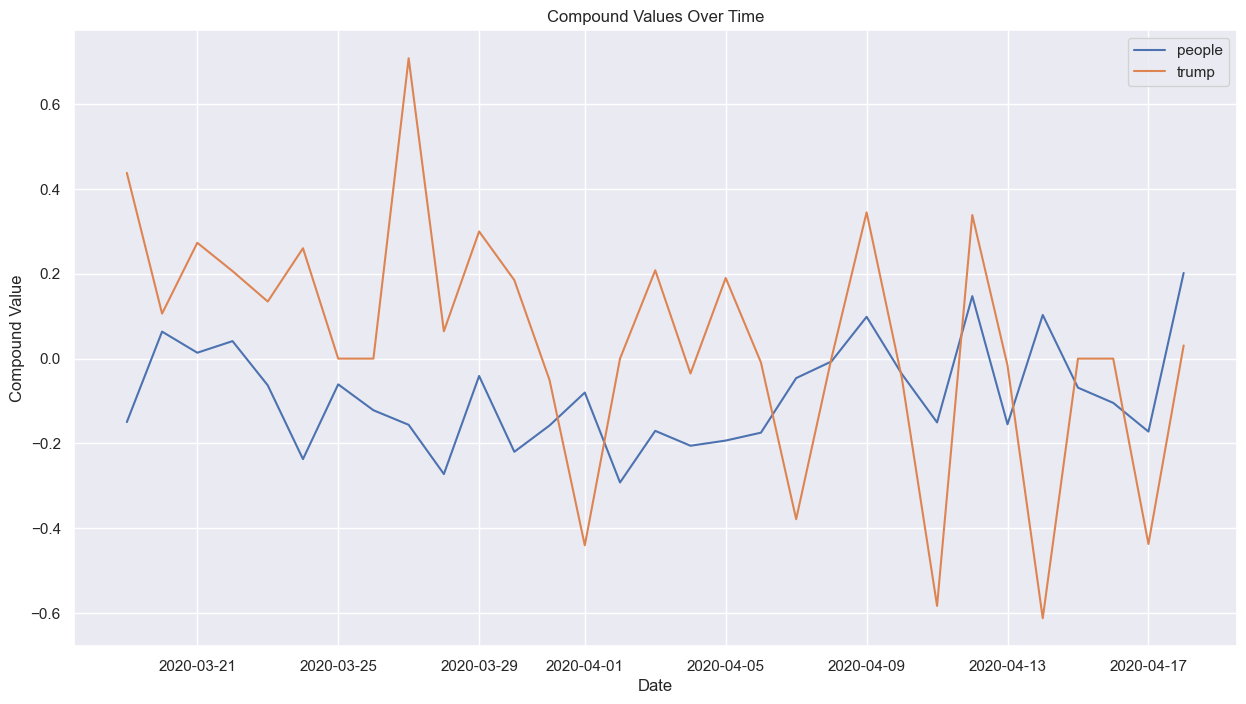

In [78]:
plt.plot(US_df_agg['date'], US_df_agg['compound'], label='people', linestyle='-')
plt.plot(freq_d_subc['date'], freq_d_subc['compound'], label='trump', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()

merge dataframes with people sentiment and trump sentiment

In [79]:
merged_dfc = pd.merge(US_df_agg, freq_d_subc, on='date', how='inner')
merged_dfc.rename(columns={'compound_x': 'people', 'compound_y': 'Trump'}, inplace=True)

Now we have a dataset with only tweets about covid, let's see if there is a correlation between the sentiment of the people about covid and the sentiment of Trump's tweets(only about covid)

In [80]:
merged_dfc['Trump_sent']= merged_dfc['Trump'].apply(lambda x: 1 if x>0 else 0 )
merged_dfc['people_sent']= merged_dfc['people'].apply(lambda x: 1 if x>0 else 0)

In [81]:
mod_1 = smf.logit(formula='Trump_sent ~ people_sent ', data=merged_dfc)
res_1 = mod_1.fit()
print(res_1.summary())

Optimization terminated successfully.
         Current function value: 0.604785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Trump_sent   No. Observations:                   31
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.1268
Time:                        15:11:05   Log-Likelihood:                -18.748
converged:                       True   LL-Null:                       -21.471
Covariance Type:            nonrobust   LLR p-value:                   0.01961
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5108      0.422     -1.212      0.226      -1.337       0.316
people_sent     2.3026    

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

### Second variable : New infected

Let's consider a timeseries of new cases of covid in US and see if the variation of the new cases can be used to predict Trump's sentiment tweets the dataset reports the absolute number of new cases, we need to calculate the variation of new cases.

In [82]:
covid = pd.read_csv('timesco/time-series-19-covid-combined.csv')
covid.head()

cov_us = covid[covid['Country/Region']=='US']
sub_cov = cov_us[(cov_us['Date'] >= start_date) & (cov_us['Date'] <= end_date)]

Add the columns with people and Trump sentiment

In [83]:
sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
sub_cov.loc[:,'Trump']= merged_dfc['Trump'].values
sub_cov.loc[:,'people']= merged_dfc['people'].values

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\344740220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\344740220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_30952\344740220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

variation of cases in new cases, in the dataframe we have absolute numbers

In [84]:
#increment in new cases
logit_df = sub_cov.copy()
logit_df['increase_new_cases'] = logit_df['Confirmed'].shift(1)-logit_df['Confirmed']/logit_df['Confirmed']

In [85]:
#standardization
logit_df['Confirmed']= (logit_df['Confirmed']-logit_df['Confirmed'].mean())/logit_df['Confirmed'].std()
logit_df['Recovered']= (logit_df['Recovered']-logit_df['Recovered'].mean())/logit_df['Recovered'].std()
logit_df['Deaths']= (logit_df['Deaths']-logit_df['Deaths'].mean())/logit_df['Deaths'].std()
logit_df['increase_new_cases']= (logit_df['increase_new_cases']-logit_df['increase_new_cases'].mean())/logit_df['increase_new_cases'].std()

In [86]:
#regression
mod5 = smf.logit(formula='trump_sent ~ increase_new_cases ', data=logit_df)
res5 = mod5.fit()
print(res5.summary())

Optimization terminated successfully.
         Current function value: 0.603617
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.1264
Time:                        15:11:05   Log-Likelihood:                -18.109
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                   0.02209
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1785      0.404     -0.442      0.658      -0.969       0.612
incre

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

From the summary we can see that the variation of new cases has a negative correlation with Trump's sentiment tweets. It is significative at 5% level, then we have predictive power.
It is reasonable since we expect that if the number of new cases is increasing, Trump's sentiment is worsening.

### Combine variables : sentiment and new cases

In [87]:
mod6 = smf.logit(formula='trump_sent ~ peopl_sent + increase_new_cases', data=logit_df)
res6 = mod6.fit()
print(res6.summary())

Optimization terminated successfully.
         Current function value: 0.426899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.3821
Time:                        15:11:05   Log-Likelihood:                -12.807
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 0.0003631
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2070      0.679     -1.777      0.076      -2.538       0.124
peopl

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

All the results we got in the previous models are confirmed, the two variables have predictive power and the model performs well. Actually the p-values are ven lower than in the previous models, both variables are significative at 2.5% level.

It seems that both variables have predictive power, let's scale the increment in new cases between -1 and 1 with min max scaler, so that they are directly comparable to the sentiment variables.

In [88]:
# Assuming 'data' is the variable you want to scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = logit_df['increase_new_cases'].values.reshape(-1, 1)  # If 'data' is a pandas Series
logit_df['scaled_new'] = scaler.fit_transform(scaled)


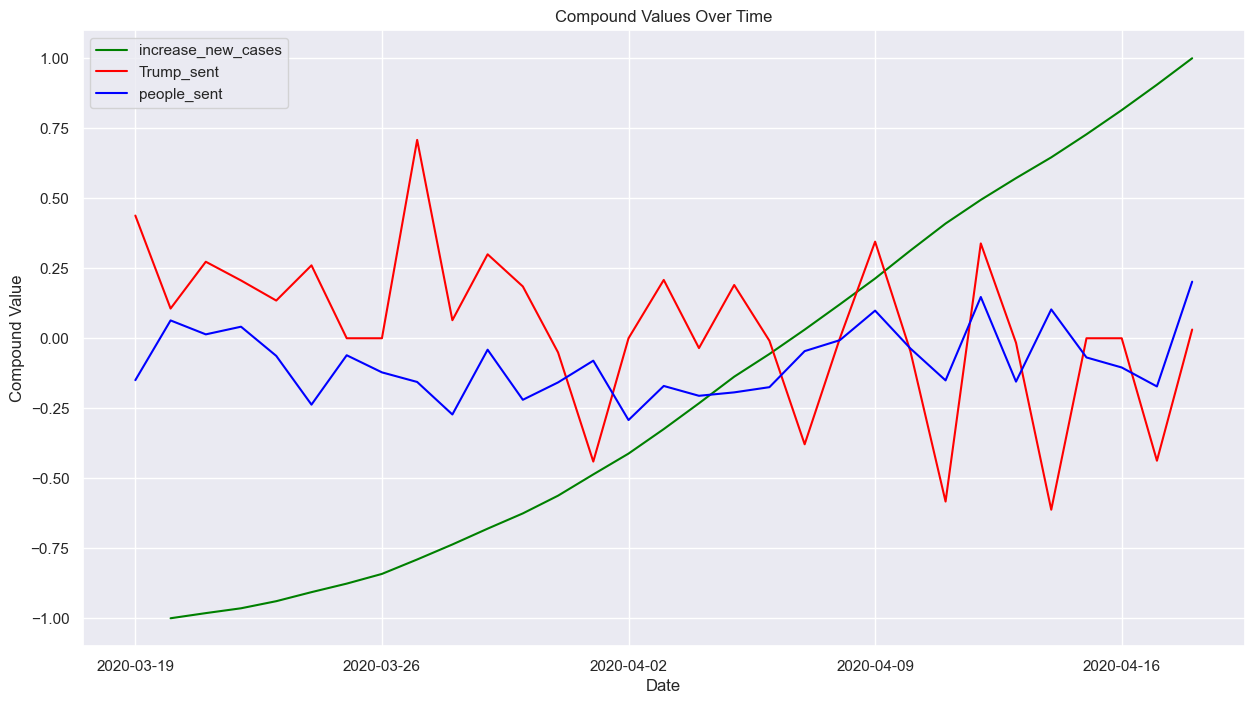

In [89]:
# plots
plt.plot(logit_df['Date'], logit_df['scaled_new'], label='increase_new_cases', linestyle='-',color='green')
plt.plot(logit_df['Date'], logit_df['Trump'], label='Trump_sent', linestyle='-',color='red')
plt.plot(logit_df['Date'], logit_df['people'], label='people_sent', linestyle='-', color='blue')

n = 7 
plt.xticks(logit_df['Date'][::n])
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()


The plot show that the two sentiment variables comove, at least is the period considered. It also noticible that the sentiments variables are negatively correlated with the variation of new cases, as expected. The trend of the variation of new cases is raising sharply, wherease the sentiment of the sentiment variables have a general negative trend.

In [90]:
y_pred = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])
y_pred = [ 1 if y>=0.5 else 0 for y in y_pred]

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

Let's plot the confusion Matrix

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarni

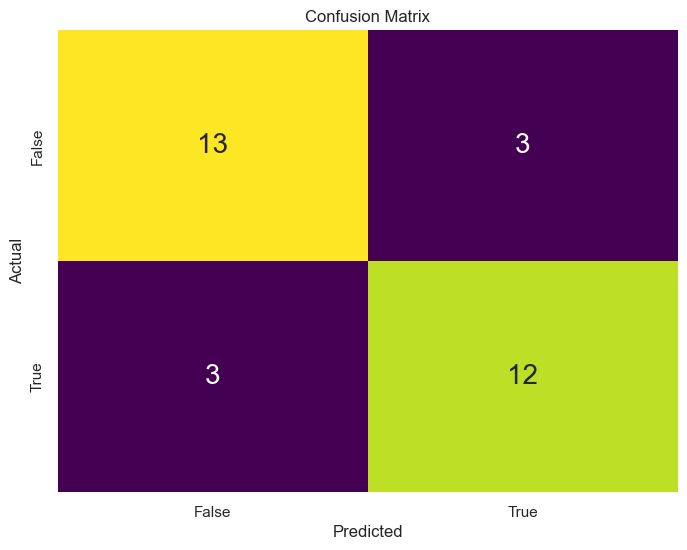

In [91]:
confusion_matrix = metrics.confusion_matrix(logit_df.trump_sent, y_pred)
labels = ['False', 'True']  

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels, annot_kws={"size": 20}, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks()
plt.yticks()

plt.show()



In [92]:
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
f1 = 2*(precision*recall)/(precision+recall)
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))

Precision: 0.800
Recall: 0.800
F1 Score: 0.800


The result we get are really good we have a precision of 0.8 and a recall of 0.8, the model is able to predict the sentiment of Trump's tweets with a good accuracy and recall. Our analysis last 30 days but the values are aggregated on a daily basis so our results can be considered reliable. 

In [93]:
#fill the miss values given with the mean value
logit_df['increase_new_cases']=logit_df['increase_new_cases'].fillna(logit_df['increase_new_cases'].mean())

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

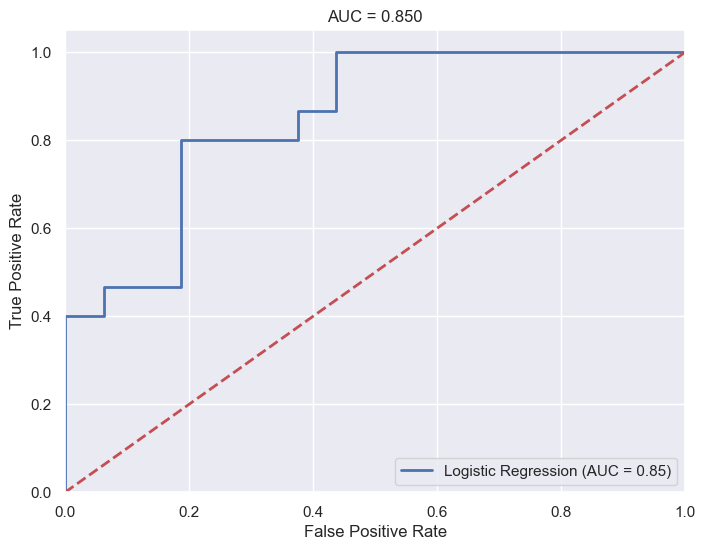

In [94]:
logit_probs = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])

# Calculate ROC curve and AUC
logit_roc_auc = roc_auc_score(logit_df['trump_sent'], logit_probs)
fpr, tpr, thresholds = roc_curve(logit_df['trump_sent'], logit_probs)
auc_score = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc, linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUC = {:.3f}".format(auc_score))
plt.xticks()
plt.yticks()
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



## Retweets per sentiment :

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Number of retweets per sentiment category')]

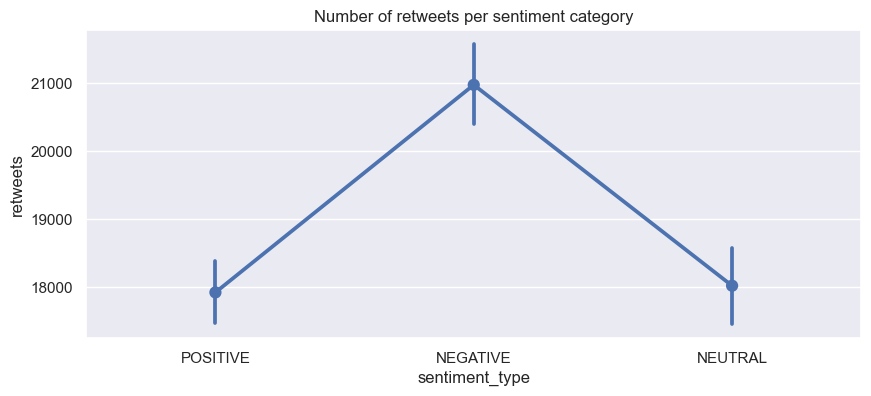

In [95]:
plt.figure(figsize=(10,4))
sns.pointplot(data,x='sentiment_type',y='retweets').set(title='Number of retweets per sentiment category')



## Study relation between categories and sentiments:

In [96]:
pivot_dem = pd.crosstab(data[data['democrats']==True].democrats, data['sentiment_type'])
pivot_biden = pd.crosstab(data[data['biden']==True].biden, data['sentiment_type'])
pivot_covid = pd.crosstab(data[data['covid_related']==True].covid_related, data['sentiment_type'])
pivot_fake_news = pd.crosstab(data[data['is_fake_news']==True].is_fake_news, data['sentiment_type'])
pivot_vaccines = pd.crosstab(data[data['vaccines']==True].vaccines, data['sentiment_type'])

pivot_df = pd.concat([pivot_dem,pivot_biden,pivot_covid,pivot_fake_news,pivot_vaccines])


In [97]:
proportion_df = 100*pivot_df.div(pivot_df.sum(axis=1), axis=0)


<Figure size 800x1200 with 0 Axes>

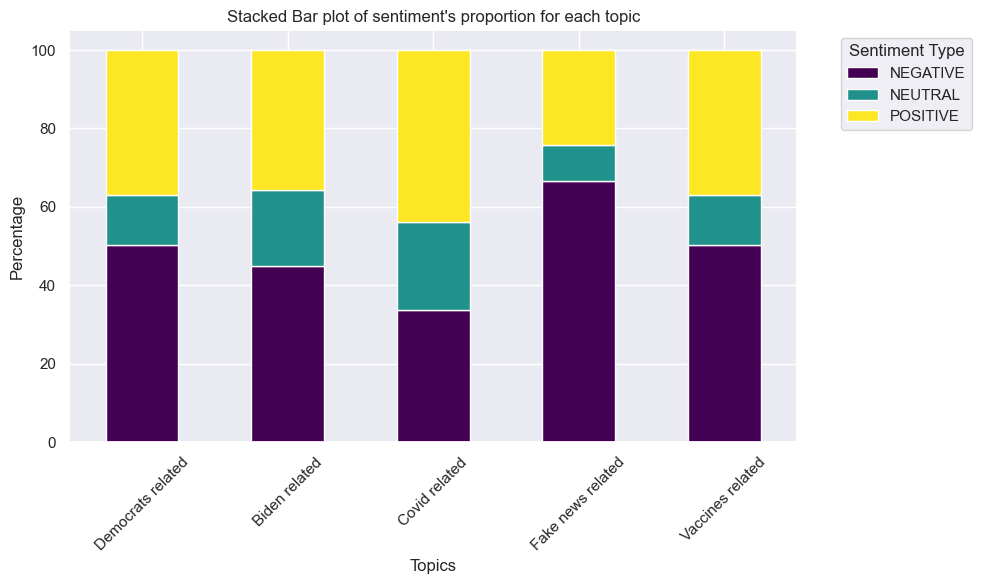

In [98]:
plt.figure(figsize=(8,12))
ax = proportion_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Stacked Bar plot of sentiment's proportion for each topic")
ax.set_xticklabels(['Democrats related','Biden related','Covid related','Fake news related','Vaccines related'])
plt.xlabel('Topics')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Retweets per sentiment for given categories ( to delete I guess)

**Caution: some 'positive' are actually sarcastic:**

In [99]:
data_biden_rel[data_biden_rel.sentiment_type=='POSITIVE'].text[1720]

'crazy bernie takes the lead in the democrat primaries  but it is looking more and more like the dems will never allow him to win  will sleepy joe be able to stumble across the finish line '

# Part 4: Causal Analysis 

In [100]:
# modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
from causalimpact import CausalImpact
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# helpers
from helpers.wiki_gtrend_visualization import load_wikipedia_df
from helpers.gtrend_visualization import load_gtrend_df, load_gtrend_hourly_df
from helpers.load_topic_hourly import request_gtrends

One of our research questions is to find whether there is a causal relationship between Trump's tweets and the number of visits on some Covid-related topics, for example Hydroxychloroquine on Wikipedia. During COVID-19 period Trump claimed that Hydroxychloroquine was a cure for COVID-19. This claim was not supported by scientific evidence, making it more of a fake news. This was further motivation to investigate this topic in particular.

## 4.1 Pre-processing

In [101]:
tweets_df = pd.read_csv('data/tweets.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')

This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [102]:
tweets_df.loc[1, 'date']

Timestamp('2020-03-03 01:34:50')

Let's focus on the Covid period:

In [103]:
tweets_covid_df = tweets_df[tweets_df['date'] >= '2019-12-01'].copy()
tweets_covid_df.sort_values(by='date')
tweets_covid_df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56,f


## 4.2 Wikipedia & GTrends Time Series

Let's see the number of tweets where Hydroxychloroquine is mentioned:

In [104]:
# Pinpoint all tweets containing the key words
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = tweets_covid_df['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# Create a column with a boolean indicating whether tweet contains a key word
new_col = analyze.reindex(tweets_covid_df.index, fill_value=False)
tweets_covid_df['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', tweets_covid_df['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [105]:
# get the dates where trump spoke about Hydroxychloroquine
hydro_tweets_times = tweets_covid_df[tweets_covid_df['Hydroxychloroquine'] == True]['date'].copy()
hydro_tweets_times = hydro_tweets_times.sort_values()
hydro_tweets_times = hydro_tweets_times.reset_index(drop=True)
hydro_tweets_times = hydro_tweets_times.dt.normalize() # set times to 00:00:00
display(hydro_tweets_times.head())
week_critical_data_hydro = (hydro_tweets_times - pd.to_timedelta((hydro_tweets_times.dt.dayofweek+1) % 7, unit='D')).unique()

0   2020-03-21
1   2020-03-24
2   2020-04-04
3   2020-04-05
4   2020-04-10
Name: date, dtype: datetime64[ns]

We want to get the global number of pageviews for the article related to hydroxychloroquine from Wikipedia and Google Trends. We will start by graphically studying the evolution of the number of queries/visits to assess whether Trump's tweets had an impact on them.

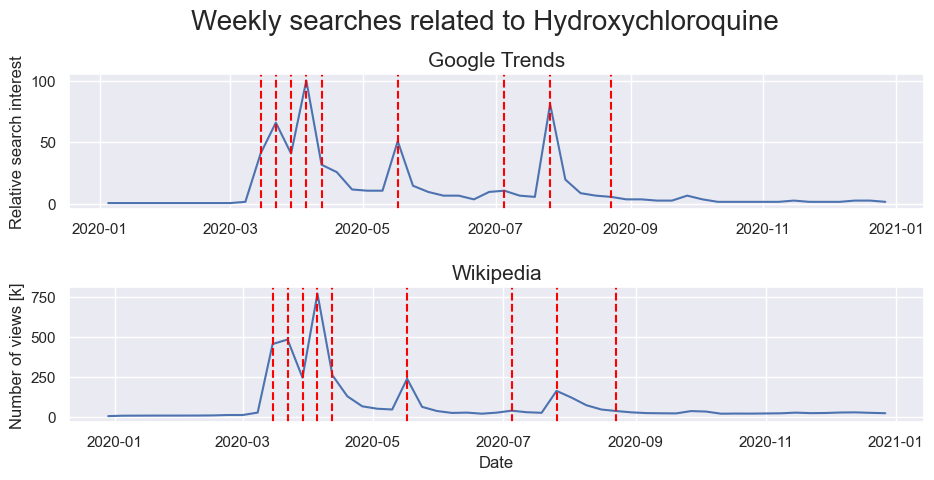

In [106]:
pagename = 'Hydroxychloroquine'
folder = 'extra_material'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(folder,filename)
gtrends_hydro_df = load_gtrend_df(folder, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

As we can see, the Wikipedia and Google trend pageviews behave simarly. Google Trends uses a relative scale from 0 to 100, while Wikipedia returns the absolute number of visits. We can see that the number of visits was almost zero until March 2020. The spikes in the graph appear almost at the same time as Trump's Tweet. We should further investigate whether there is a causal relationship between Trump's tweets and the number of visits.

To get a finer visualization of the impact of Trump's tweets on Wikipedia searches, we can also plot Wikipedia searches on hydroxychloroquine at a daily granularity (this granularity is not available on Google Trends).

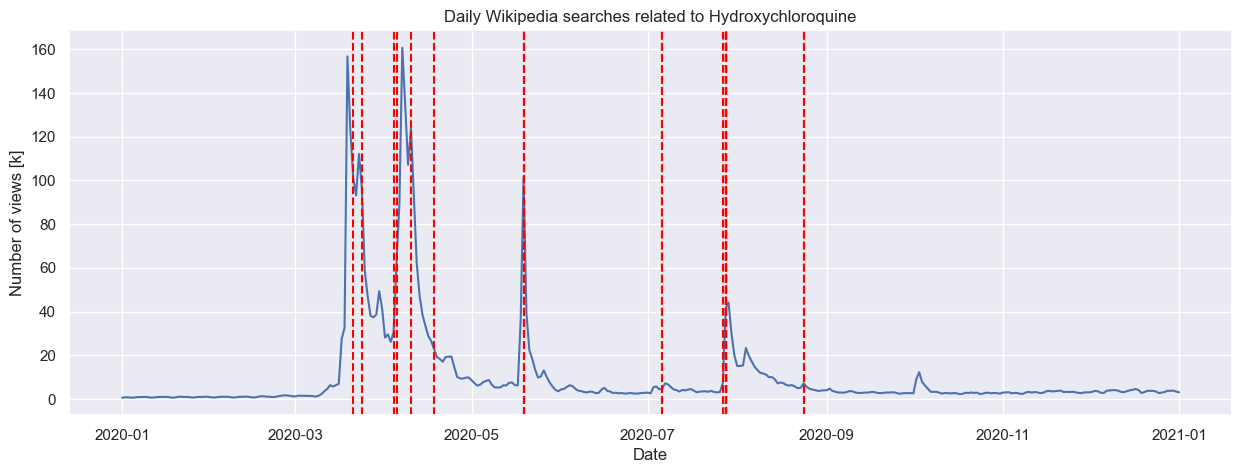

In [107]:
plt.figure(figsize = (15, 5))

plt.title('Daily Wikipedia searches related to {pagename}'.format(pagename=pagename))
plt.ylabel('Number of views [k]')
plt.plot(daily_wikipedia_hydro_df['Views']/10**3)
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in hydro_tweets_times]
plt.xlabel('Date')
plt.show()

As we can see from the graph above, Trump's tweets on hydroxychloroquine seem to precede certain attention peaks (e.g. the second big peak at the start of April), but come after others (e.g. the first big peak, around mid-March). A possibile explanation is simply that the tweets sometimes cause attention, whereas other times public interests makes Trump tweet about the topic. Another one is that both are caused by external factors, and that Trump's and the public's reaction times vary: sometimes Trump reacts the fastest, and other times the public does.

As hydroxychloroquine  was not the only fake news spread by Trump, we repeated the same preliminary analysis and visualizations for other fake news, to get a better idea of how well our observations for hydroxychloroquine generalize to other topics.

### 1)  Swine Flu

Trump tweeted a lot about the Swine Flu. Let's graphically study the relationship between Trump's tweets and public interest for the topic.

Number of tweets talking about Swine Flu is:  26


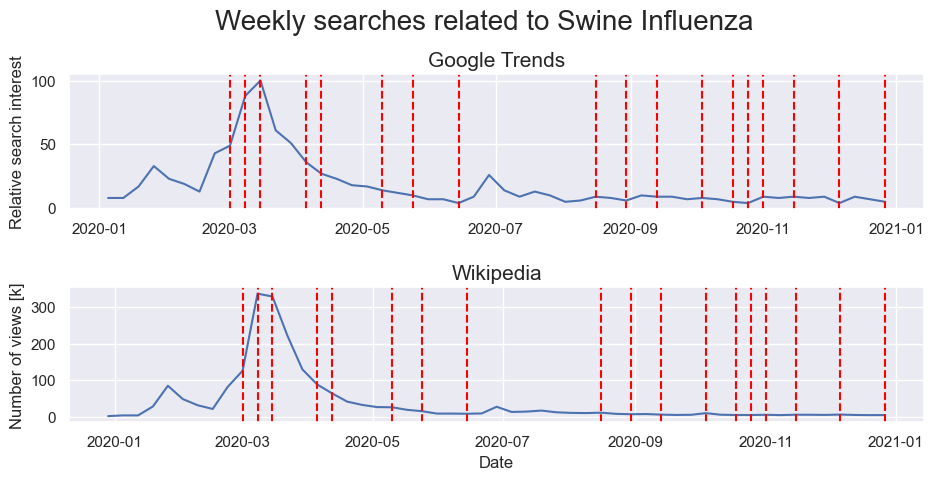

In [108]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(folder, filename)
gtrends_df = load_gtrend_df(folder, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

From the plot, it seems that peaks in popularity tend to start before Trump's tweets (especially the first two), but some of Trump's tweets might still have had some effect. His first tweet seemed to have increased the slope of the main popularity peak, and his tweets in mid-june 2020 might have cause the subsequent peak in interest (a smaller one, but Trump's tweet clearly precedes it this time).

### 2)  China Laboratory-Leak Virus

Trump was not tweeting directly about the fact that covid escaped from a lab, however, he tweeted a lot about the "China Virus", did this feed the trend?

Number of tweets talking about COVID-19 lab leak theory is:  49


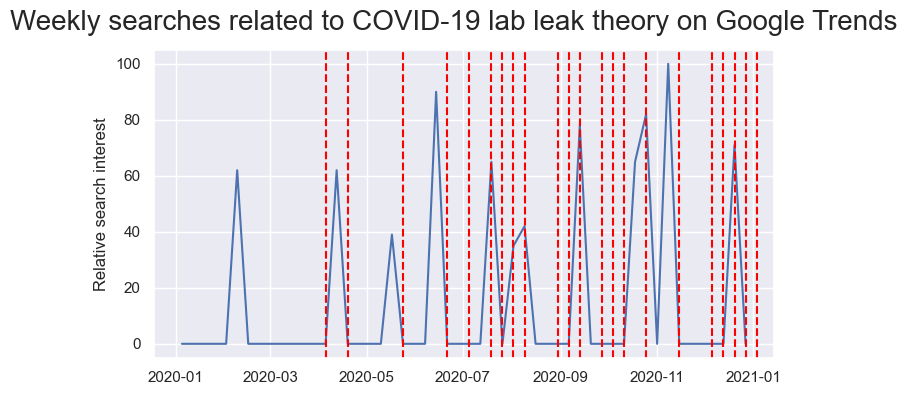

In [109]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(folder, filename)
gtrends_df = load_gtrend_df(folder, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

For the 'Lab Leak Theory' the graph is much more hectic and it's hard to conclude on any causal effect of Trump's tweets on online trends.

## 4.3 Granger Causality

To better understand Trump's potential causal impact on online trends, we will focus on the topic of hydroxychloroquine. 
The plot of daily Wikipedia views made it difficult to assess whether Trump causes tweets or the other way around. To investigate this, we therefore chose to conduct a [Granger causality](https://en.wikipedia.org/wiki/Granger_causality) test. 

"The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another".
The [null hypothesis](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html) is that "the the time series the first column is NOT Granger caused by the time series in the other columns".

In [110]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=daily_wikipedia_hydro_df['Views'].index, columns=['Date'])

for date in hydro_tweets_times:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine wiki and tweets
wiki_tweets_hydro_df = daily_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)
display(wiki_tweets_hydro_df.sample(5))

,Views,Tweets
Date,,
2020-09-11,2892,0
2020-03-31,41539,0
2020-04-21,17018,0
2020-01-17,876,0
2020-08-17,7199,0


First, let's investigate whether tweets Granger cause views.

In [111]:
print("\n DO TWEETS GRANGER CAUSE VIEWS? \n")
tweets_cause_views = grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2, verbose=False)

print(f"p-value, 1 lag: {tweets_cause_views[1][0]['ssr_ftest'][1]}")
print(f"p-value, 2 lags: {tweets_cause_views[2][0]['ssr_ftest'][1]}")


 DO TWEETS GRANGER CAUSE VIEWS? 

p-value, 1 lag: 2.577509249130668e-05
p-value, 2 lags: 1.7666280235258214e-06


c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(F)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(F)


The p-values for the Granger causality tests for both lags 1 and 2 are well below the threshold of 0.05. The test is therefore statistically signifcant and the views time series is Granger caused by tweets.


Let's repeat our analysis the other way around: do views Granger cause Trump's tweets?

In [112]:
print("DO VIEWS GRANGER CAUSE TWEETS?")
views_cause_tweets = grangercausalitytests(wiki_tweets_hydro_df, 2, verbose=False)

print(f"p-value, 1 lag: {views_cause_tweets[1][0]['ssr_ftest'][1]}")
print(f"p-value, 2 lags: {views_cause_tweets[2][0]['ssr_ftest'][1]}")

DO VIEWS GRANGER CAUSE TWEETS?
p-value, 1 lag: 0.8244239959804691
p-value, 2 lags: 0.008218461970935929


c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(F)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(F)


This time, only the p-value for 2 lags is below the statistical threshold of significance of 0.05. According to [Wikipedia](https://en.wikipedia.org/wiki/Granger_causality), however, "the null hypothesis of no Granger causality is not rejected if and only if no lagged values of an explanatory variable have been retained in the regression". In other words, having signifance for one lagged value is enough. We can thus conclude that views also cause Trump's tweets.

How to interpret the fact that the two time series Granger cause each other? As mentioned earlier, Granger causality just means that one time series is useful at predicting the other. There can therefore be two explanations to our results:
- sometimes Trump causes tweets, other times public interest causes Trump to tweet;
- or both time series are actually caused by external factors. Sometimes Trump's reacts faster, and sometimes the public get interested first. The varying reaction times could explain the Granger causality results.

## 4.4 Causal Impact

To further investigate whether Trump's tweet cause views, we will focus on his first tweet, which coincides with a big peak in interest (both on Wikipedia and Google).
The [Causal Impact](https://google.github.io/CausalImpact/CausalImpact.html) library in Python allows us perform a test which can tell us if there is a causal relation between Trump's first tweet and the number of Google queries on Hydroxychloroquine. We are focusing on Google Trends, as they allows us to study time series at hourly granularity. 
To run this analysis we need to build a dataframe with the following columns:
- data index: the date of the observation of our time series.
- y: the number of visits to the the page of Hydroxychloroquine (test variable).
- x: the number of visits to a set of pages (the control variables), which were not affected by the intervention (Trump's first tweet).

The following [assumptions](https://pypi.org/project/pycausalimpact/) need to be verified to conduct this test : "the response variable can be precisely modeled by a linear regression with what is known as "covariates" (or X) that must not be affected by the intervention that took place".

We decided to take the time series of the following five topics, which for obvious reasons should not have been affected by Trump's tweet, as control variables: climate, coffee, news, shop and time.

### A) Fetch GTrends Time Series at Hourly Granularity

We start by fetching the time series of interest from Google Trends. We focus on a window of 4 days centred around Trump's first tweet. Note that we are using the time series of global searches on hydroxychloroquine. Unfortunately, more local series were not available for the data of interest.

In [113]:
# Select tweet number
tweet_nb = 0
alias = f"tweet_{tweet_nb}"

# Request data from GTrends API (both hydro and Google) and save it
tweet_time = hydro_tweets_times[tweet_nb].replace(minute=0, second=0)
print(f"Time of Trump's first tweet: {tweet_time}")
start_time = tweet_time - timedelta(hours=48)
end_time = tweet_time + timedelta(hours=48)

# # Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Time of Trump's first tweet: 2020-03-21 00:00:00


In [114]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)
folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

,hydro,climate,coffee,news,shop,time
Date,,,,,,
2020-03-19 00:00:00,12,66,78,70,63,90
2020-03-19 01:00:00,38,65,93,69,60,95
2020-03-19 02:00:00,36,85,83,66,59,88
2020-03-19 03:00:00,17,100,74,64,55,90
2020-03-19 04:00:00,14,77,71,71,57,91


### B) Causal Impact

We then select the pre-period (time before Trump's tweet) and the post-period (the time after his tweet) for the causal analysis.

In [115]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], tweet_time]
post_period = [tweet_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

[Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-21 00:00:00')]
[Timestamp('2020-03-21 01:00:00'), Timestamp('2020-03-23 00:00:00')]


We verify the assumption that the test variable can be modelled as a linear regression with the covariates.

In [116]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\patsy\util.py:672: DeprecationWarning: is_categorica

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hydro   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     4.675
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00170
Time:                        15:11:16   Log-Likelihood:                -214.49
No. Observations:                  49   AIC:                             441.0
Df Residuals:                      43   BIC:                             452.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -176.8627     57.521     -3.075      0.004    -292.864     -60.861
coffee         0.4218      0.312      1.350      0.184      -0.208       1.052
climate        0.1784      0.269      0.663      0.511      -0.364       0.721
news           1.0879      0.425      2.559      0.014       0.230       1.945
shop           0.4764      0.436      1.093      0.280      -0.402       1.355
time           0.7178      0.451      1.592      0.119      -0.191       1.627
==============================================================================
Omnibus:                        3.813   Durbin-Watson:                   0.691
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                3.481
Skew:                           0.648   Prob(JB):                        0.175
Kurtosis:                       2.845   Cond. No.                     3.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values associated with several coefficientss are significant (< 0.05), and the R² = 0.54. The fit is therefore pretty good, but the results of our causal analysis should still be interpreted with caution.

We can now run the causal impact analysis.

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments h

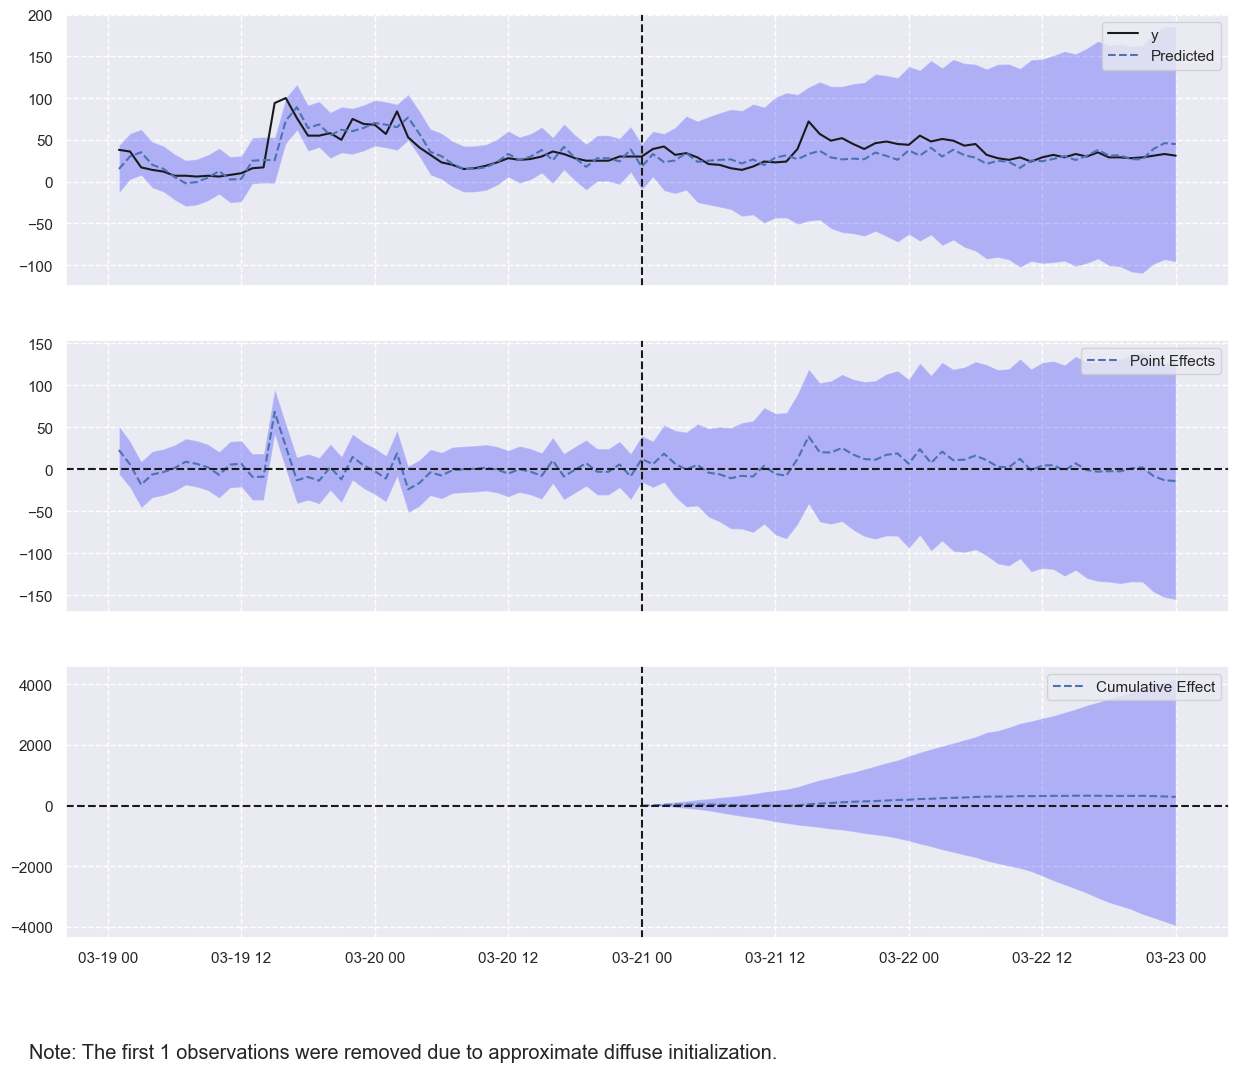

In [117]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()

The causal impact analysis corroborates the visual inspection of the Google Trends time series: the peak in interest on hydroxychloroquine preceded Trump's first tweet. His tweet therefore doesn't seem to have had a strong impact on interest. Note, however, that we are using global trends time series. It might be that Trump had a local impact (though probably not strong) on Google searches, e.g. in the United States.

### D) Alternative Hypothesis

As explained earlier, an alternative possibility to explain why online trends time series and Trump's tweets Granger cause each other is that an external factor is the "real" cause of the surge of interest.

Some online research revealed that the big peak in interest mid-March might have caused by the two following major events, which both took place on March 16, 2020:
- a mobility changepoint in the United States following restrictions, according to [Manoel et al.](https://arxiv.org/abs/2005.08505),
- "A study on the use of hydroxychloroquine in patients with SARS-CoV-2 was published (online via Youtube) - The preliminary data from this small study was heard round the world", as quoted from [Saag et al.](https://jamanetwork.com/journals/jama/fullarticle/2772921).

We therefore tried to reconduct a causal impact analysis, considering March 16, 5 P.M. (GMT, so between 9 A.M and 12 A.M. in the USA) as our intervention time.

Again, we start by fetching the global data over a window of 4 days (not exactly centred around the chosen intervention time due to data unavailability on Google Trends).

In [118]:
# Request data from GTrends API (both hydro and Google) and save it
treatment_time = pd.Timestamp(2020,3,16,17,0,0)
print(f"Tweet time: {treatment_time}")
start_time = pd.Timestamp(2020,3,15,12,0,0)
end_time = pd.Timestamp(2020,3,19,12,0,0)

print(f"start time: {start_time}")
print(f"end time: {end_time}")

alias = "publi"

# Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'y
# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Tweet time: 2020-03-16 17:00:00
start time: 2020-03-15 12:00:00
end time: 2020-03-19 12:00:00


In [119]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

IndexError: list index out of range

We then select the pre- and post-periods for the causal analysis.

In [ ]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], treatment_time]
post_period = [treatment_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

Before conducting the analysis, we verify the assumption that the time series can me modelled by a linear regression in the pre-period.

In [ ]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

Several coefficients show statistical significance (p-value < 0.05) and the R²=0.52 is fairly high. Still, the results should once more be interpreted with caution.

We can now run the causal impact analysis.

In [ ]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()

The causal impact analysis shows that the intervention on March 16 (the mobility restrictions, the publication or both - perhaps even other events, this period was quite hectic) has a strong impact on Google Trends searches on Wikipedia. 

In conclusion, Trump's tweets and online Trends are correlated, and both time series contain information that can predict the other (cf. Granger causality). A focus on the first tweet suggests that rather than the tweets causing public online interest or vice versa, it is quite likely that external events were the real cause of interest. This closer analysis was only conducted on one of his tweets and for one topic, however. The results should therefore be interpreted with caution, and a more systematic study should be done to generalize our observations.